In [1]:
import polars as pl
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from mpl_toolkits.mplot3d import axes3d
import datetime
import pytz

In [2]:
def guess_theta(re, alpha):
    # 各成分で0~1までの乱数をn_count個生成
    n_count = 10**5
    t = np.random.uniform(-np.pi, np.pi, n_count)
    #t = np.linspace(-np.pi, np.pi, 3600)
    y_klein = np.random.uniform(0, 1, n_count)
    # クライン-仁科の式
    klein_nishina = 0.5*re**2 *(1/(1+alpha*(1-np.cos(t))))**2 * (1+np.cos(t)**2 + alpha**2 * (1-np.cos(t))**2 / (1+alpha*(1-np.cos(t))))
    # クライン-仁科の式のグラフの下側にあるy_kleinのインデックスを取得
    klein_index_list = np.where(y_klein < klein_nishina)[0]
    # 取得したインデックスに該当するtの値を1つずつ取り出し，新たなリストに格納
    guess_theta_list = [t[i] for i in klein_index_list]
    return guess_theta_list

In [3]:
def cross_section_radiation(E, df_xcom):
    # 与えたEの値を超えるdf_xcomの”Energy”の値のインデックスを全て取得しそのうちの0番目のもの
    # http://taustation.com/numpy-where/#1
    index_max = int(np.where(df_xcom[:, 0].to_numpy() > E)[0][0])
    index_min = index_max - 1
    # コンプトン散乱の場合の２点をつなぐ直線の式の変化の割合と切片を求める
    dycom_dx = (df_xcom[index_max, 2]-df_xcom[index_min, 2])/(df_xcom[index_max, 0]-df_xcom[index_min, 0])
    b_com = df_xcom[index_max, 2] - dycom_dx*df_xcom[index_max, 0]
    # 散乱断面積を推定する
    sigma_com = dycom_dx*E + b_com
    # 光電効果による吸収の場合の２点をつなぐ直線の式の変化の割合と切片を求める
    dyabs_dx = (df_xcom[index_max, 3]-df_xcom[index_min, 3])/(df_xcom[index_max, 0]-df_xcom[index_min, 0])
    b_abs = df_xcom[index_max, 3] - dyabs_dx*df_xcom[index_max, 0]
    # 吸収断面積を推定する
    sigma_abs = dyabs_dx*E + b_abs
    # 吸収断面積と散乱断面積の比を求める
    return sigma_abs/(sigma_com + sigma_com)

In [4]:
df_xcom = pl.read_csv('xcom_data_1130.csv')
df_xcom.head(10)

Energy,Rayleigh,Compton,Absorption
f64,f64,f64,f64
0.001,4304.0,1.234,1.788e6
0.0015,4132.0,2.271,806600.0
0.002,3935.0,3.31,438300.0
0.002484,3742.0,4.266,271800.0
0.002484,3742.0,4.266,476500.0
0.002534,3722.0,4.364,562900.0
0.002586,3701.0,4.463,665000.0
0.002586,3701.0,4.463,839200.0
0.003,3533.0,5.246,672500.0


In [5]:
df_xcom.describe

<bound method DataFrame.describe of shape: (47, 4)
┌──────────┬──────────┬─────────┬────────────┐
│ Energy   ┆ Rayleigh ┆ Compton ┆ Absorption │
│ ---      ┆ ---      ┆ ---     ┆ ---        │
│ f64      ┆ f64      ┆ f64     ┆ f64        │
╞══════════╪══════════╪═════════╪════════════╡
│ 0.001    ┆ 4304.0   ┆ 1.234   ┆ 1.788e6    │
│ 0.0015   ┆ 4132.0   ┆ 2.271   ┆ 806600.0   │
│ 0.002    ┆ 3935.0   ┆ 3.31    ┆ 438300.0   │
│ 0.002484 ┆ 3742.0   ┆ 4.266   ┆ 271800.0   │
│ …        ┆ …        ┆ …       ┆ …          │
│ 0.5      ┆ 3.934    ┆ 23.17   ┆ 28.41      │
│ 0.6      ┆ 2.773    ┆ 21.55   ┆ 18.6       │
│ 0.8      ┆ 1.59     ┆ 19.05   ┆ 9.878      │
│ 1.0      ┆ 1.029    ┆ 17.18   ┆ 6.226      │
└──────────┴──────────┴─────────┴────────────┘>

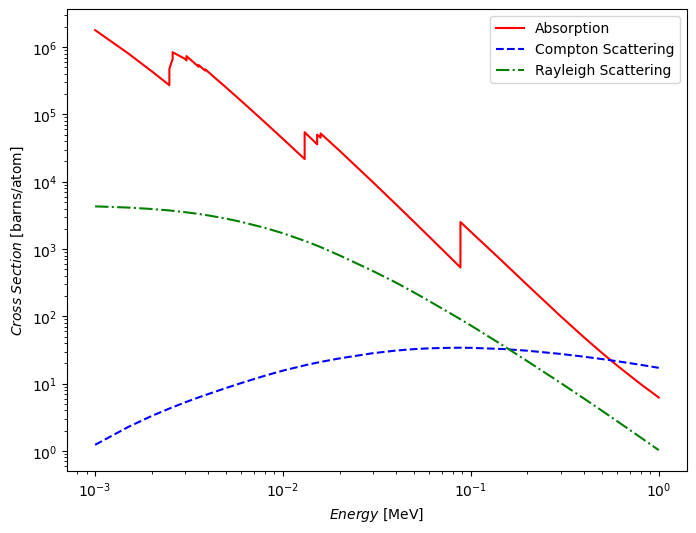

In [6]:
# グラフの各種設定
fig_0 = plt.figure(
    figsize = (8, 6),
    facecolor = "white",
    edgecolor = "black",
)
# グラフの出力位置の設定
ax_0 = fig_0.add_subplot(111)
ax_0.plot(df_xcom["Energy"], df_xcom["Absorption"],"-", label = "Absorption", color = "red")
ax_0.plot(df_xcom["Energy"], df_xcom["Compton"], "--", label = "Compton Scattering", color = "blue")
ax_0.plot(df_xcom["Energy"], df_xcom["Rayleigh"], "-.", label = "Rayleigh Scattering", color = "green")
ax_0.set_xlabel(r'$Energy$ [MeV]')
ax_0.set_ylabel(r'$Cross \ Section$ [barns/atom]')
ax_0.set_xscale('log')
ax_0.set_yscale('log')
ax_0.legend(loc = 'best')

spline_interpolate_compton = interpolate.interp1d(df_xcom["Energy"].to_numpy(), df_xcom["Compton"].to_numpy(), kind="cubic")
new_compton_csa = spline_interpolate(energy)

In [7]:
cross_section_radiation(0.662, df_xcom)

0.382579542719615

In [8]:
df_xcom["Energy"].to_numpy()

array([0.001   , 0.0015  , 0.002   , 0.002484, 0.002484, 0.002534,
       0.002586, 0.002586, 0.003   , 0.003066, 0.003066, 0.003301,
       0.003554, 0.003554, 0.003699, 0.003851, 0.003851, 0.004   ,
       0.005   , 0.006   , 0.008   , 0.01    , 0.01304 , 0.01304 ,
       0.015   , 0.0152  , 0.0152  , 0.01553 , 0.01586 , 0.01586 ,
       0.02    , 0.03    , 0.04    , 0.05    , 0.06    , 0.08    ,
       0.088   , 0.088   , 0.1     , 0.15    , 0.2     , 0.3     ,
       0.4     , 0.5     , 0.6     , 0.8     , 1.      ])

In [9]:
p = 0.8
initial_N = 1.0e+6

In [10]:
df = pl.DataFrame({
    'step_0': [1]*int(initial_N),
})

In [11]:
i = 1
while True:
    df = df.with_columns(pl.lit(np.random.rand(int(initial_N))).alias(f"new_dice_{i-1}"))
    df = df.with_columns(
            pl.when((pl.col(f"step_{i-1}") == 1.0) & (p > pl.col(f"new_dice_{i-1}")))
            .then(pl.lit(1).alias(f"step_{i}"))
            .otherwise(pl.lit(0).alias(f"step_{i}"))
        )
    if df[:, f"step_{i}"].sum().to_numpy()[0] == 0:
        break
    i += 1

In [12]:
sum_result = df.select(pl.col(r"^step_[\d]+$")).sum()
sum_result

step_0,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11,step_12,step_13,step_14,step_15,step_16,step_17,step_18,step_19,step_20,step_21,step_22,step_23,step_24,step_25,step_26,step_27,step_28,step_29,step_30,step_31,step_32,step_33,step_34,step_35,step_36,step_37,step_38,step_39,step_40,step_41,step_42,step_43,step_44,step_45,step_46,step_47,step_48,step_49,step_50,step_51,step_52,step_53,step_54,step_55,step_56,step_57,step_58,step_59,step_60,step_61,step_62,step_63,step_64,step_65,step_66,step_67,step_68,step_69,step_70,step_71,step_72,step_73,step_74
i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
1000000,799830,639828,512391,409936,328080,262018,209546,168165,134687,107943,86370,69140,55370,44246,35463,28388,22867,18268,14612,11671,9266,7479,6052,4808,3826,3043,2421,1950,1579,1265,1007,790,629,508,398,310,243,190,153,120,93,69,56,46,33,29,22,21,18,14,12,7,6,5,3,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0


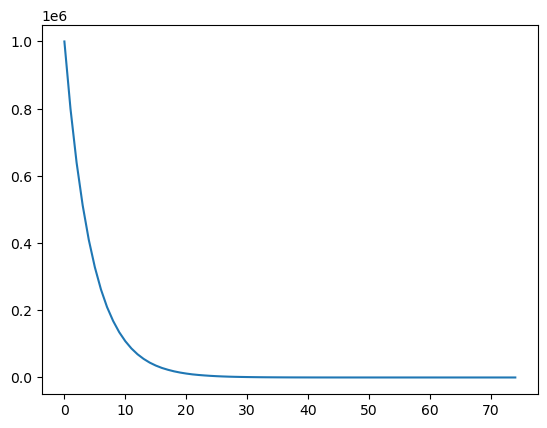

In [13]:
plt.plot(np.arange(sum_result.shape[1]), sum_result.to_numpy()[0])